In [ ]:
#!pip install tensorflow
#!pip install keras
#!pip install pydot
#!pip install graphviz

# Regresión con Redes Neuronales


## 1) Generacion del Dataset: Flujo Caótico

Como primer paso, vamos a generar la serie temporal a partir de un sistema dinámico. Usaremos los códigos que ya venimos usando durtante la materia para hacerlo.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def ecuaciones(z, t, *args, **kwargs):
    '''
    Recibe:
       z: Variables del sistema [x,y]

    Devuelve:
       x_dot, y_dot: valor de las derivadas para cada variable
    '''
    x = z[0]
    y = z[1]
    z= z[-1]
    a=args[0]
    b=args[1]
    c=args[-1]
    # sistema de lorenz
    x_dot = a*(y - x)
    y_dot = x*(b -z)-y
    z_dot = x*y-c*z

    return x_dot, y_dot, z_dot    

def rk4(dxdt, x, t, dt, *args, **kwargs):
    x = np.asarray(x)
    k1 = np.asarray(dxdt(x, t, *args, **kwargs))*dt
    k2 = np.asarray(dxdt(x + k1*0.5, t, *args, **kwargs))*dt
    k3 = np.asarray(dxdt(x + k2*0.5, t, *args, **kwargs))*dt
    k4 = np.asarray(dxdt(x + k3, t, *args, **kwargs))*dt
    return x + (k1 + 2*k2 + 2*k3 + k4)/6


def integrar_ecuaciones(total_time,dt,X0,*args):

    '''
    Recibe:
       total_time: Tiempo total del integración
       dt: Paso temporal (h del método)
       X0: Lista con [x0,y0] valores iniciales de la integración
       params: Lista con los parámetros del sistema
    Devuelve:
       x_s, y_s: Vectores con las soluciones para ambas variables
       num_steps: Numero de pasos de integracion
    '''


    t = np.arange(0, total_time, dt)
    # Empty vectors para los x(t) y y(t)
    xt = np.zeros_like(t)
    yt = np.zeros_like(t)
    zt = np.zeros_like(t)

    # Set initial values
    xt[0], yt[0], zt[0] = X0
    for i in range(len(t)-1):
      # COMPLETAR
      xt[i+1], yt[i+1], zt[i+1] = rk4(ecuaciones, [xt[i], yt[i], zt[i]], t[i], dt, *args)
    return xt, yt , zt, len(t)

# def integrar_ecuaciones(total_time,dt,X0):

#     '''
#     Recibe:
#        total_time: Tiempo total del integración
#        dt: Paso temporal (h del método)
#        X0: Lista con [x0,y0] valores iniciales de la integración
#        params: Lista con los parámetros del sistema
#     Devuelve:
#        x_s, y_s: Vectores con las soluciones para ambas variables
#        num_steps: Numero de pasos de integracion
#     '''

#     num_steps = int(np.divide(total_time,dt))

#     # Empty vectors
#     xs = np.empty(num_steps)
#     ys = np.empty(num_steps)
#     zs = np.empty(num_steps)

#     # Set initial values
#     xs[0], ys[0], zs[0] = X0

#     # Empty vectors
#     x_dot = np.empty(num_steps)
#     y_dot = np.empty(num_steps)
#     z_dot = np.empty(num_steps)

#     # Set initial derivatives values
#     x_dot[0], y_dot[0], z_dot[0] = ecuaciones(xs[0], ys[0], zs[0])

#     # Integramos con método de Euler
#     for i in range(num_steps-1):
#         x_dot[i], y_dot[i], z_dot[i] = ecuaciones(xs[i], ys[i], zs[i])
#         xs[i + 1] = xs[i] + (x_dot[i] * dt)
#         ys[i + 1] = ys[i] + (y_dot[i] * dt)
#         zs[i + 1] = zs[i] + (z_dot[i] * dt)

#     return xs, ys, zs, num_steps

In [13]:
# Simulamos los datos
total_time = 5000
dt = 0.001
X0 = (10, 10, 0)

xs, ys, zs, num_steps = integrar_ecuaciones(total_time,dt,X0,10, 28, 8/3)

Grafiquemos la solución del sistema.

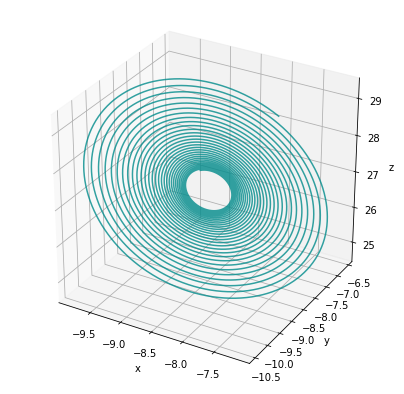

In [50]:
# Numero de puntos a graficar
N = 27000
s=9000
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection="3d")
#ax.plot3D(xs[0:N],ys[0:N],zs[0:N], 'darkcyan', alpha=0.8)
ax.plot3D(xs[s:N],ys[s:N],zs[s:N], 'darkcyan', alpha=0.8)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_zlim(10,30)
#ax.set_xlim(-15,0)
#ax.set_ylim(10,30)
plt.show()

Me voy a quedar con los puntos de x(t). Primero vamos a normalizar y subsamplear la a serie temporal.

In [15]:
# Proporcion entre train y test
proporcion = 0.75 #75% del training set y 35% del test set 

# Indice de separacion entre train y test
indice_test = int(proporcion * num_steps)

# Subsampleo temporal de la señal
subsampleo = 100

#Maximo de la señal para normalizar
maximo = np.max(np.abs(xs))

# Separamos la serie en 2 partes, una para el train set y otra para el test set.
# aca normaliza por el maximo de la serie temporal
training_set_scaled = np.divide(xs[:indice_test:subsampleo],maximo)
test_set_scaled = np.divide(xs[indice_test::subsampleo],maximo)

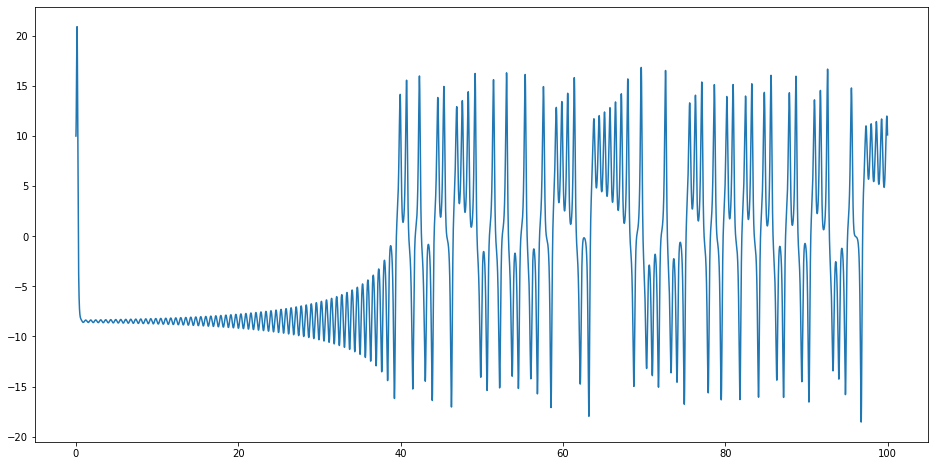

In [16]:
len(xs) # el len total de la serie temporal es 1,000,000
fig = plt.figure(figsize = (16,8))
plt.plot(np.arange(0,total_time,dt)[:100000],xs[:100000])

In [ ]:
#subsampleo cada 100 
len(xs)/100 #=10,000 de los cuales 7,500 van a training y 3,500 van a test 

10000.0

In [ ]:
training_set_scaled.shape

(7500,)

In [ ]:
test_set_scaled .shape

(2500,)

Ahora, armaremos el dataset a utilizar a partir de esta serie temporal. Entrenaremos la red de manera de que la entrada sean N pasos consecutivos de la serie y su objetivo sea predecir el siguiente paso. 

La cantidad de pasos para atras que verá la red esta determinada por la variable `look_back`.

In [17]:
look_back = 20 # es el tama;o del input. 20 puntos de la serie temporal y quiero predecir el punto 21

X_train = []
Y_train = []

# Recorremos la serie correspondiente al train y armamos el dataset
for i in range(look_back, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-look_back:i])
    Y_train.append(training_set_scaled[i])
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_test = []
Y_test = []

# Recorremos la serie correspondiente al test y armamos el dataset
for i in range(look_back, len(test_set_scaled)):
    X_test.append(test_set_scaled[i-look_back:i])
    Y_test.append(test_set_scaled[i])
X_test, Y_test = np.array(X_test), np.array(Y_test)

In [ ]:
X_train[-1] # corresponde a training_set_scaled[-21:-1] 

array([-0.12707873, -0.29777711, -0.40281443, -0.41226879, -0.31862361,
       -0.13986823,  0.08364354,  0.29812008,  0.44911104,  0.49517641,
        0.41920063,  0.23403597, -0.01967376, -0.28201247, -0.48757404,
       -0.5816613 , -0.53463447, -0.3507182 , -0.06877105,  0.24560047])

In [ ]:
X_train[1]# corresponde a training_set_scaled[1:21] # tiene un valor diferente con X_train[0]

array([ 0.17068212, -0.16063405, -0.46935383, -0.67672486, -0.72518959,
       -0.59401635, -0.30650198,  0.07350007,  0.45540152,  0.74289786,
        0.85343639,  0.69323914,  0.31051713, -0.06142123, -0.4287389 ,
       -0.70804518, -0.82444629, -0.73992316, -0.46490086, -0.05824825])

In [ ]:
X_train[0] # corresponde a training_set_scaled[0:20]

array([ 0.44441375,  0.17068212, -0.16063405, -0.46935383, -0.67672486,
       -0.72518959, -0.59401635, -0.30650198,  0.07350007,  0.45540152,
        0.74289786,  0.85343639,  0.69323914,  0.31051713, -0.06142123,
       -0.4287389 , -0.70804518, -0.82444629, -0.73992316, -0.46490086])

**El X_train no incluye el training_set_scaled[-1], pues es eso lo que quiere predecir**

Noten las dimensiones de las matrices obtenidas.

In [ ]:
# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Train y shape", Y_train.shape)

print("Test matrix shape", X_test.shape) # es (7480, 20)
print("Test y shape", Y_test.shape)

Train matrix shape (7480, 20)
Train y shape (7480,)
Test matrix shape (2480, 20)
Test y shape (2480,)


Tengo 7480 instancias de training para mostrarle a mi red. Cada instancia consiste en 20 valores. De testeo tengo 2480 instancias.

Veamos como sería uno de los elementos con los que vamos a entrenar a la red y la salida (predicción) deseada para ese elemento.

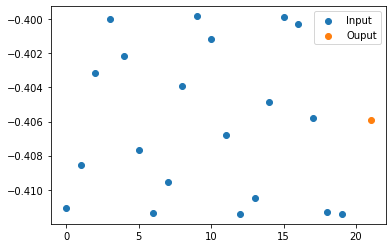

In [18]:
# Numero de instancia que queremos grafiacar
i = 9
largo = len(X_train[i])
# Puntos que vamos a usar como imput
plt.scatter(np.arange(largo),X_train[i], label='Input')
# Output deseado
plt.scatter(largo+1,Y_train[i], label='Ouput')
plt.legend()
plt.show()

## 2) Redes Neuronales - Regresión

### Modelado

Vamos a definir una red neuronal de la misma forma que lo hicimos anteriormente.

In [19]:
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation

# building a linear stack of layers with the sequential model
model = Sequential()
model.add(Dense(128, input_shape=(look_back,)))   #input de tamanio 20=look_back  y no le aclaro la activacion, porque? 
#model.add(Dense(128, input_shape=(look_back,), activation='relu'))  # tambien funciona                  
# model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

Las principales diferencias respecto al problema de clasificación son las siguientes:

*   La neurona de salida es una única neurona con activación lineal. Recuerden que ahora buscamos predecir una cantidad, no la probabilidad de pertenencia a una clase.
*   La funcion de costo sera el `mean_squared_error`, ya que queremos minimizar las desviaciones respecto al valor original.



In [20]:
# compiling the sequential model
model.compile(loss='mse', metrics=['mean_absolute_error'], optimizer='adam')

Ya podemos entrenar nuestrad red regresora.

In [21]:
# training the model and saving metrics in history
history = model.fit(X_train, Y_train,
          batch_size=32, epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/10
1172/1172 [==============================] - 2s 2ms/step - loss: 0.0035 - mean_absolute_error: 0.0300 - val_loss: 8.4720e-04 - val_mean_absolute_error: 0.0220
Epoch 2/10
1172/1172 [==============================] - 2s 2ms/step - loss: 4.4079e-04 - mean_absolute_error: 0.0156 - val_loss: 4.1056e-04 - val_mean_absolute_error: 0.0160
Epoch 3/10
1172/1172 [==============================] - 2s 2ms/step - loss: 3.1435e-04 - mean_absolute_error: 0.0133 - val_loss: 1.0398e-04 - val_mean_absolute_error: 0.0075
Epoch 4/10
1172/1172 [==============================] - 2s 2ms/step - loss: 3.3495e-04 - mean_absolute_error: 0.0136 - val_loss: 2.1718e-04 - val_mean_absolute_error: 0.0118
Epoch 5/10
1172/1172 [==============================] - 2s 2ms/step - loss: 2.2544e-04 - mean_absolute_error: 0.0113 - val_loss: 2.0968e-04 - val_mean_absolute_error: 0.0110
Epoch 6/10
1172/1172 [==============================] - 2s 2ms/step - loss: 2.2096e-04 - mean_absolute_error: 0.0111 - val_loss: 3.407

### Analizamos los resultados

Ploteamos la loss function (mean square error) y la metrica mean absolute error

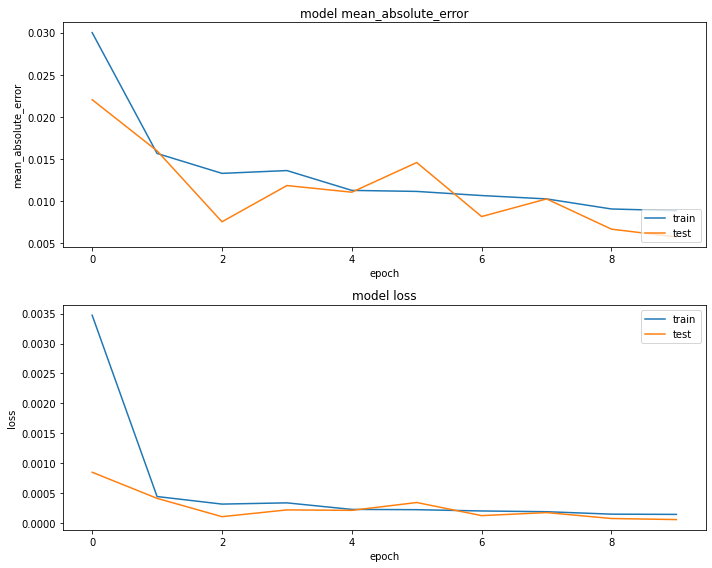

In [22]:
# plotting the metrics
fig = plt.figure(figsize = (10,8))
plt.subplot(2,1,1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

Los valores de error son bastante bajos en proporcion a los valores de entrada. Comparemos como se ven la parte de la serie temporal del test real vs la predicha por la red.

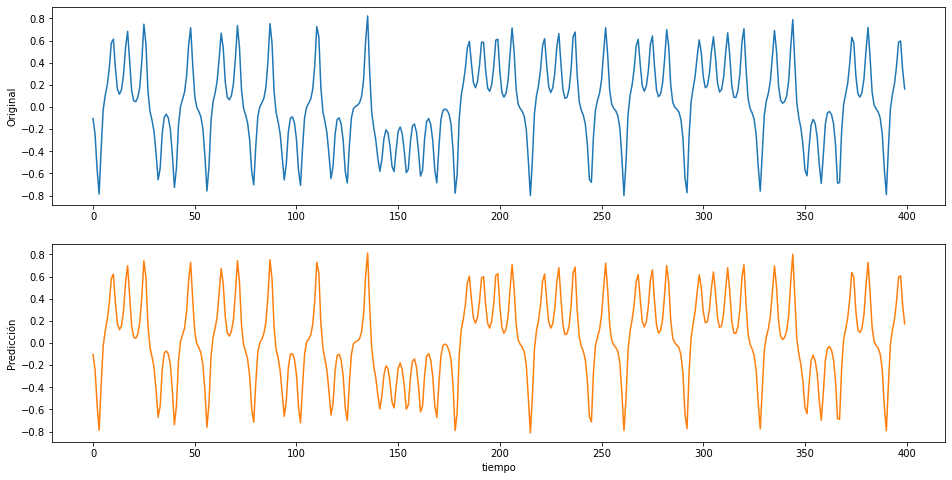

In [23]:
pasos_adelante = 400
Y_test_pred = model.predict(X_test)

fig = plt.figure(figsize = (16,8))
plt.subplot(2,1,1)
plt.plot(Y_test[0:pasos_adelante]) # celeste, lo posta 
plt.ylabel('Original')
plt.subplot(2,1,2)
plt.plot(Y_test_pred[0:pasos_adelante],c='C1') # naranja, lo que predice la red
plt.ylabel('Predicción')
plt.xlabel('tiempo')
plt.show()

**Ejercicios:** 


*   Detenerse en este punto y responder la siguiente pregunta: ¿Significa entonces que el modelo de alguna manera capturo la dinámica caótica del sistema? 
*   ¿Como explica que ambas curvas sean tan similares?



### Predicción de multiples pasos adelante

La predicción con la cual entrenamos y evaluamos el modelo es para un único paso en el futuro. Es decir estamos siempre prediciendo el siguiente valor de la serie temporal, pero condicionado por los `look_back` pasos anteriores, los cuales se obtuvieron del atractor original. 

Para evaluar una predicción del modelo a largo plazo y poder determinar si la red neuronal efectivamente esta capturando la dinamica de las ecuaciones diferenciales, deberíamos no solo predecir el siguiente paso, sino ver que pasa cuando miramos n pasos hacia adelante.

Para realizar esto, debemos predecir el siguiente paso y luego usar ese mismo paso como entrada de la proxima predicción y así sucesivamente. Eso es lo que hace el código a continuación:

In [24]:
pasos_adelante = 400

# Tomamos el primer vector del X_test
vec_actual = X_test[0]

# Preparamos una lista vacia que vamos a ir llenando con los valores predichos
lista_valores = []

# Recorremos n pasos hacia adelante
for i in range(pasos_adelante):

    #predecimos el paso siguiente
    nuevo_valor = model.predict(vec_actual.reshape(1,vec_actual.shape[0]))

    # Lo agregamos a la lista
    lista_valores.append(nuevo_valor[0][0])

    # Actualizmaos el vector actual con este paso
    vec_actual = np.roll(vec_actual, -1) # roll manda al primer elemento del array a la ultima posicion
    vec_actual[-1] = nuevo_valor[0][0]

lista_valores = np.asarray(lista_valores)

Ahora si, comparemos este serie temporal predicha por la red con la serie verdadera. Para compararlas, preste atención al tamaño de los máximos y mínimos.

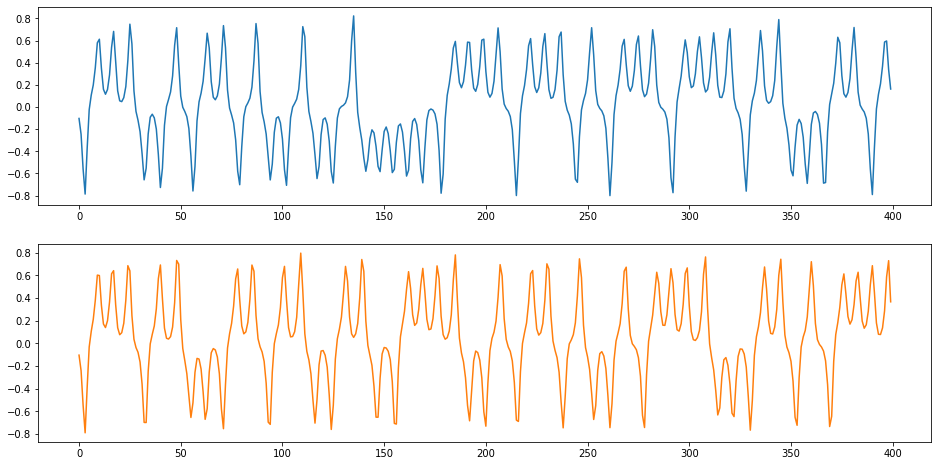

In [25]:
fig = plt.figure(figsize = (16,8))
plt.subplot(2,1,1)
plt.plot(Y_test[0:pasos_adelante]) # la posta (celeste)
plt.subplot(2,1,2)
plt.plot(lista_valores,c='C1') # lo predicho por la red (naranja)

**Ejercicios:** 

*   ¿Que puede decir de la predicción en este caso? ¿Mejoró o empeoró respecto a la anterior?
*   Vuelva a reproducir los resultados pero esta vez utilizando la variable z del Rossler. Antes de ejecutarlo, piense si espera que le sea mas facil o mas dificil a la red esta tarea.
*   Repita el procedimiento, pero esta vez para un sistema de Lorenz. Modifique el integrador numerico de manera que utilice el metodo rk4 en lugar del de Euler.